# Now lets explore the latent space a litte

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd

from autoencoder import AutoEncoder
import pickle

import umap

/home/amal/anaconda3/envs/gen/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amal/anaconda3/envs/gen/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amal/anaconda3/envs/gen/lib/python3.10/site-packages/umap/distances.py:108

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mpl.rcParams['figure.dpi'] = 150

## Start by loading the model and the validation set

In [3]:
out_path = Path("/home/amal/UbuntuDocuments/projects/generative_modelling/saved_models")

In [4]:
latent_dim = 200

model = AutoEncoder(latent_dim=latent_dim)
model.to(device)
checkpoint_path = out_path / f"autoencoder_epoch_14.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequ

In [5]:
attribute_labels = [
    '5_o_Clock_Shadow',
    'Arched_Eyebrows',
    'Attractive',
    'Bags_Under_Eyes',
    'Bald',
    'Bangs',
    'Big_Lips',
    'Big_Nose',
    'Black_Hair',
    'Blond_Hair',
    'Blurry',
    'Brown_Hair',
    'Bushy_Eyebrows',
    'Chubby',
    'Double_Chin',
    'Eyeglasses',
    'Goatee',
    'Gray_Hair',
    'Heavy_Makeup',
    'High_Cheekbones',
    'Male',
    'Mouth_Slightly_Open',
    'Mustache',
    'Narrow_Eyes',
    'No_Beard',
    'Oval_Face',
    'Pale_Skin',
    'Pointy_Nose',
    'Receding_Hairline',
    'Rosy_Cheeks',
    'Sideburns',
    'Smiling',
    'Straight_Hair',
    'Wavy_Hair',
    'Wearing_Earrings',
    'Wearing_Hat',
    'Wearing_Lipstick',
    'Wearing_Necklace',
    'Wearing_Necktie'
]

In [6]:
data_path = "/home/amal/UbuntuDocuments/data/torch_datasets"
validation_data =  datasets.CelebA(data_path, split="valid", transform=transforms.PILToTensor(), download=True)

Files already downloaded and verified


In [7]:
batch_size = 1024
val_dataloader = DataLoader(validation_data, batch_size=batch_size,)

In [8]:
def encode_dataset(
    model: torch.nn.Module, 
    dataloader: DataLoader,
    device,
):

    encoded = []
    attributes = []
    
    model.eval()
    with torch.no_grad():
        for indx, batch in enumerate(dataloader):
            input_image = batch[0]
            input = torch.tensor(input_image/255, dtype=torch.float).to(device)
            _enc = model.encode(input)
            encoded.append(_enc.detach().cpu())
            attributes.append(batch[1])

            if indx > 6:
                break

    return torch.cat(encoded, dim=0), torch.cat(attributes, dim=0)

In [9]:
encoded, attributes = encode_dataset(model, val_dataloader, device)

/tmp/ipykernel_10211/1741056253.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input_image/255, dtype=torch.float).to(device)


In [10]:
encoded.shape

torch.Size([8192, 200])

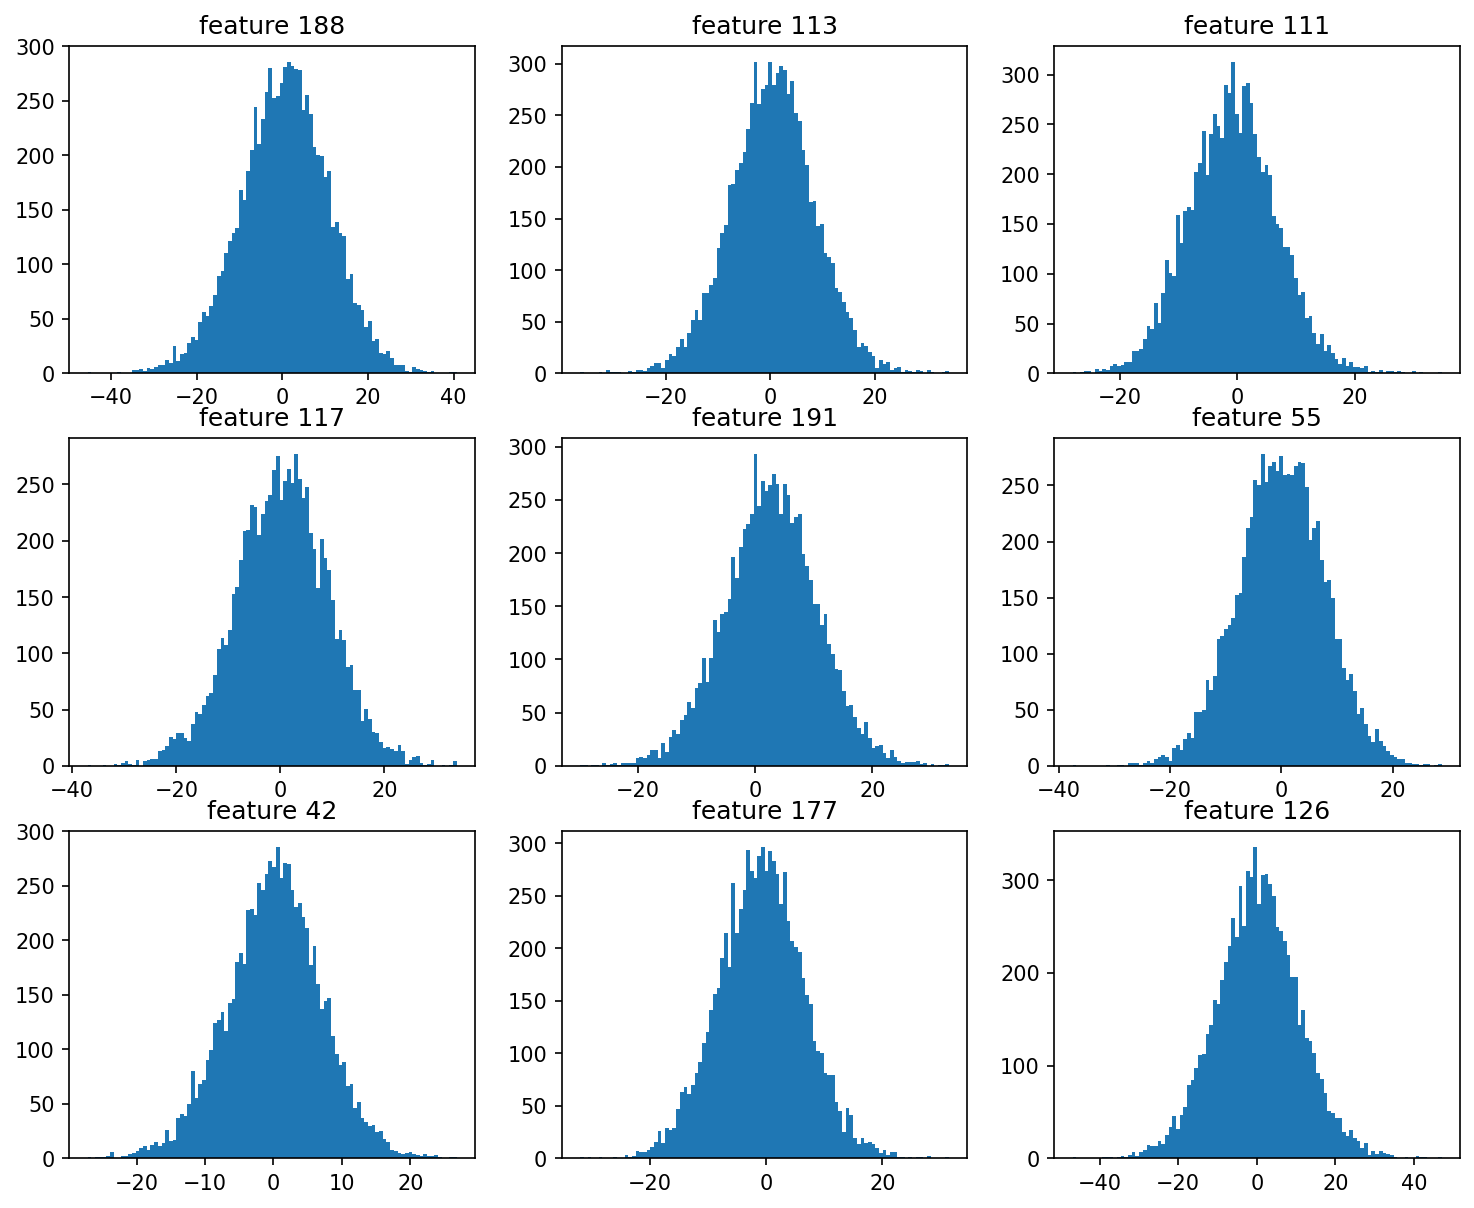

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
fig.tight_layout()
axes = axes.flatten()

indices = np.random.choice(np.arange(latent_dim), len(axes), replace=False)

for i, feature in enumerate(indices):

    axes[i].hist(encoded[:, feature], bins=100)
    axes[i].set_title(f"feature {feature}")

In [12]:
encoded = encoded.cpu().detach().numpy()
attributes = attributes.cpu().detach().numpy()

In [13]:
dim_reduction = umap.UMAP(n_components=2, n_neighbors=4)

In [14]:
reduced = dim_reduction.fit_transform(encoded)

In [22]:
#sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1])

In [17]:
attributes.shape

(8192, 40)

In [18]:
[*(enumerate(attribute_labels))]

[(0, '5_o_Clock_Shadow'),
 (1, 'Arched_Eyebrows'),
 (2, 'Attractive'),
 (3, 'Bags_Under_Eyes'),
 (4, 'Bald'),
 (5, 'Bangs'),
 (6, 'Big_Lips'),
 (7, 'Big_Nose'),
 (8, 'Black_Hair'),
 (9, 'Blond_Hair'),
 (10, 'Blurry'),
 (11, 'Brown_Hair'),
 (12, 'Bushy_Eyebrows'),
 (13, 'Chubby'),
 (14, 'Double_Chin'),
 (15, 'Eyeglasses'),
 (16, 'Goatee'),
 (17, 'Gray_Hair'),
 (18, 'Heavy_Makeup'),
 (19, 'High_Cheekbones'),
 (20, 'Male'),
 (21, 'Mouth_Slightly_Open'),
 (22, 'Mustache'),
 (23, 'Narrow_Eyes'),
 (24, 'No_Beard'),
 (25, 'Oval_Face'),
 (26, 'Pale_Skin'),
 (27, 'Pointy_Nose'),
 (28, 'Receding_Hairline'),
 (29, 'Rosy_Cheeks'),
 (30, 'Sideburns'),
 (31, 'Smiling'),
 (32, 'Straight_Hair'),
 (33, 'Wavy_Hair'),
 (34, 'Wearing_Earrings'),
 (35, 'Wearing_Hat'),
 (36, 'Wearing_Lipstick'),
 (37, 'Wearing_Necklace'),
 (38, 'Wearing_Necktie')]

In [26]:
attr = 'Blond_Hair'

sel_index = attribute_labels.index(attr)
labels =  attributes[:, sel_index] == 1

In [27]:
# sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels)
# plt.legend(title='Smoker', loc='upper left', labels=[attr, 'Nah Bruh'])

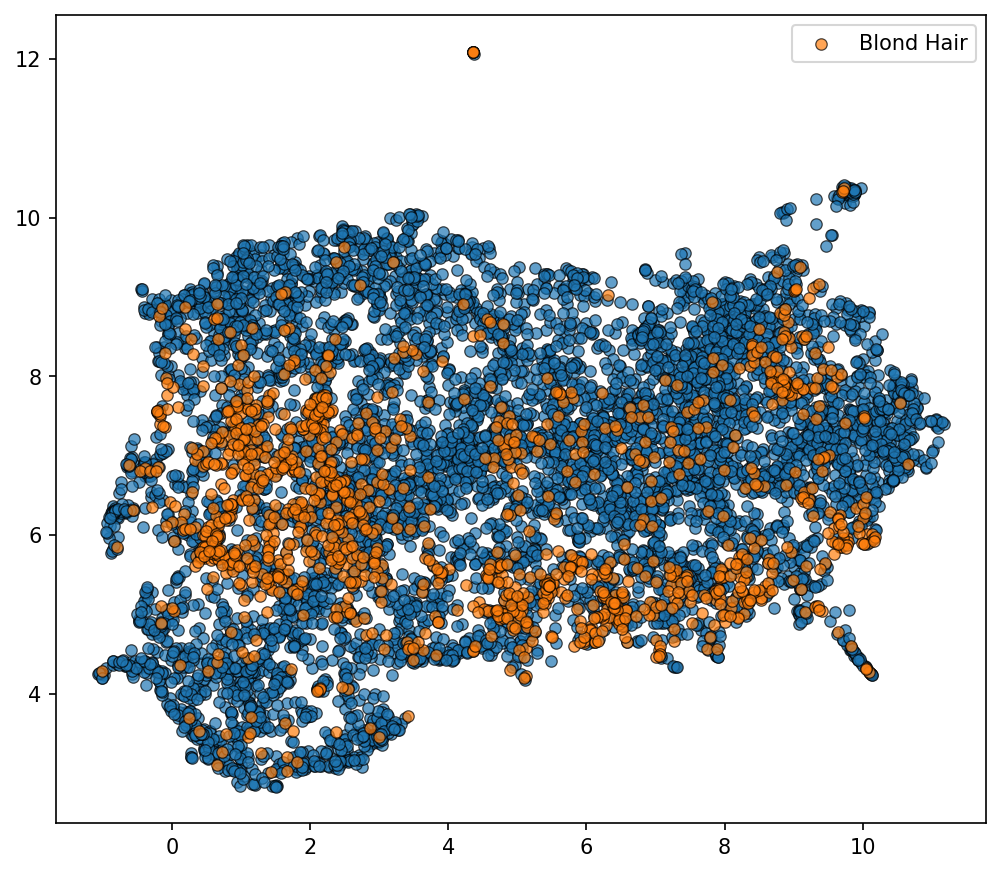

In [28]:
fig = plt.figure(figsize=(8, 7))

size = 30
e_color = 'black'
linewidth=0.6
alpha=0.7

plt.scatter(x=reduced[attributes[:, sel_index] != 1, 0], y=reduced[attributes[:, sel_index] != 1, 1], s=size, edgecolors=e_color, linewidth = linewidth, alpha=alpha)
plt.scatter(x=reduced[attributes[:, sel_index] == 1, 0], y=reduced[attributes[:, sel_index] == 1, 1], s=size, edgecolors=e_color, linewidth =linewidth, alpha=alpha, label=attr.replace("_", " "))

plt.legend()